In [39]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
import os
warnings.filterwarnings('ignore')
import pickle 

In [2]:
data=pd.read_csv("../Data/customer_churn_dataset.csv")

In [3]:
data

,customer_id,tenure,monthly_charges,total_charges,contract,payment_method,internet_service,tech_support,online_security,support_calls,churn
0,1,52,54.20,2818.40,Month-to-month,Credit,DSL,No,Yes,1,No
1,2,15,35.28,529.20,Month-to-month,Debit,DSL,No,No,2,No
2,3,72,78.24,5633.28,Month-to-month,Debit,DSL,No,No,0,No
3,4,61,80.24,4894.64,One year,Cash,Fiber,Yes,Yes,0,No
4,5,21,39.38,826.98,Month-to-month,UPI,Fiber,No,No,4,Yes
...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,36,69.51,2502.36,Two year,Cash,DSL,No,Yes,0,Yes
19996,19997,10,59.88,598.80,Month-to-month,UPI,Fiber,Yes,No,1,No
19997,19998,6,42.96,257.76,Month-to-month,Credit,Fiber,No,No,2,No
19998,19999,7,102.85,719.95,Month-to-month,Debit,DSL,Yes,No,2,No


In [4]:
data1=data.copy()

In [5]:
### EDA

In [6]:
data.isnull().sum()

customer_id            0
tenure                 0
monthly_charges        0
total_charges          0
contract               0
payment_method         0
internet_service    2013
tech_support           0
online_security        0
support_calls          0
churn                  0
dtype: int64

In [7]:
data.shape

(20000, 11)

In [8]:
data.columns

Index(['customer_id', 'tenure', 'monthly_charges', 'total_charges', 'contract',
       'payment_method', 'internet_service', 'tech_support', 'online_security',
       'support_calls', 'churn'],
      dtype='object')

In [9]:
outliers=['customer_id', 'tenure', 'monthly_charges', 'total_charges', 'contract',
       'payment_method', 'internet_service', 'tech_support', 'online_security',
       'support_calls', 'churn']

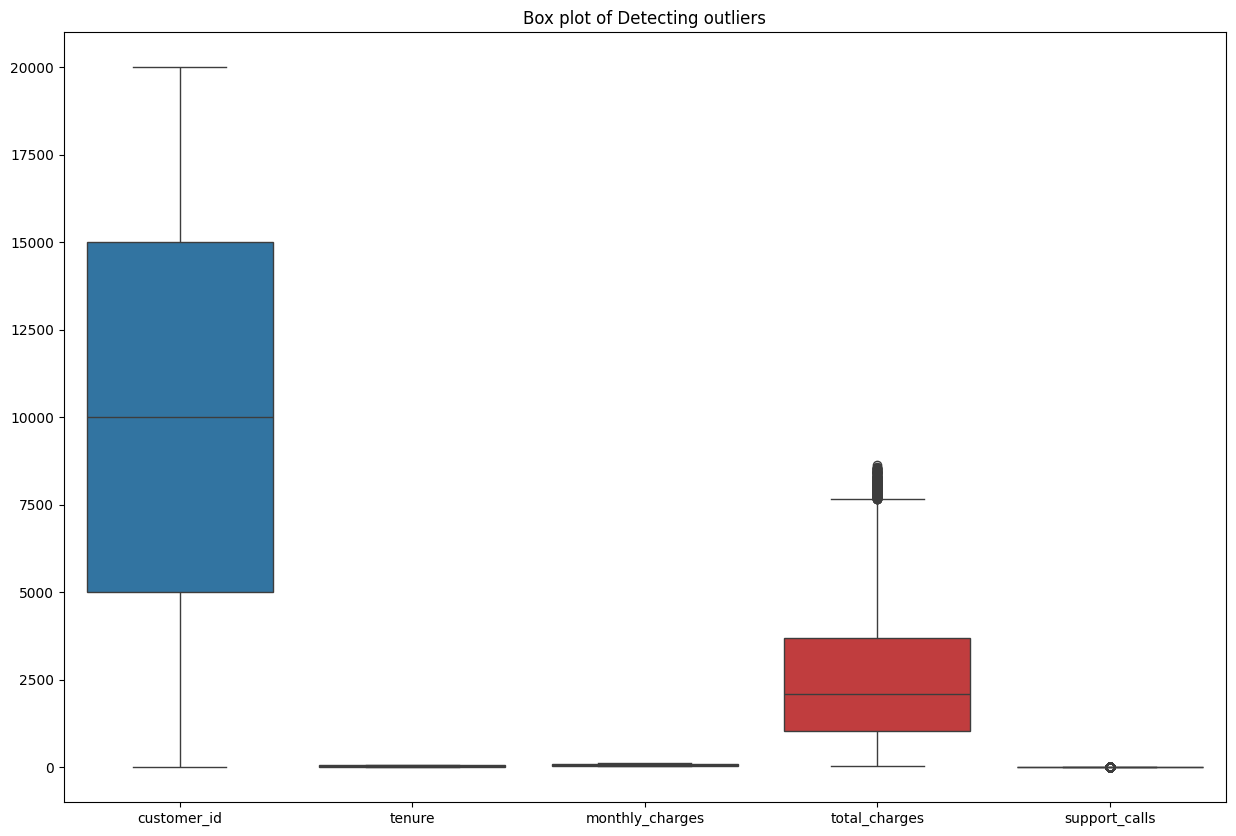

In [10]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data[outliers])
plt.title("Box plot of Detecting outliers")
plt.show()

In [11]:
### Filling some Null values 

In [12]:
data["internet_service"] = data["internet_service"].fillna(data["internet_service"].mode()[0])

In [13]:
data.drop("customer_id",axis=1,inplace=True)

In [14]:
data.isnull().sum()

tenure              0
monthly_charges     0
total_charges       0
contract            0
payment_method      0
internet_service    0
tech_support        0
online_security     0
support_calls       0
churn               0
dtype: int64

In [15]:
### Some Visualizations

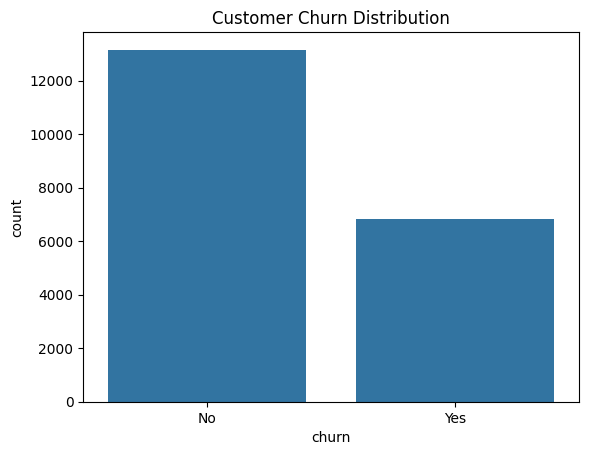

In [16]:
# Shows how many customers are leaving vs staying.
sns.countplot(x="churn", data=data)
plt.title("Customer Churn Distribution")
plt.show()
#This plot shows whether the dataset is imbalanced and how many customers churned.

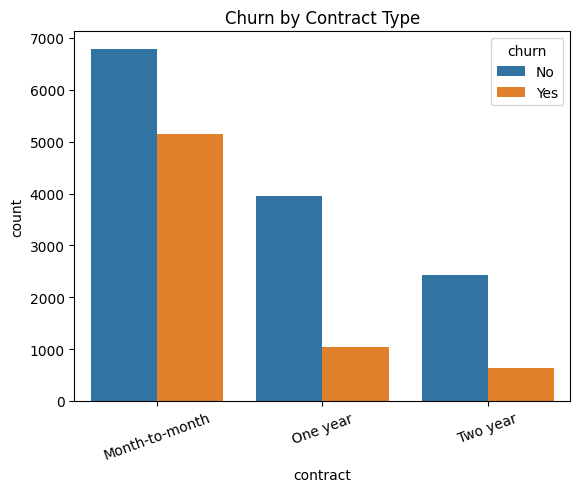

In [17]:
#Customers with month-to-month contracts churn more.
sns.countplot(x="contract", hue="churn", data=data)
plt.title("Churn by Contract Type")
plt.xticks(rotation=20)
plt.show()
#Customers with short-term contracts are more likely to churn.

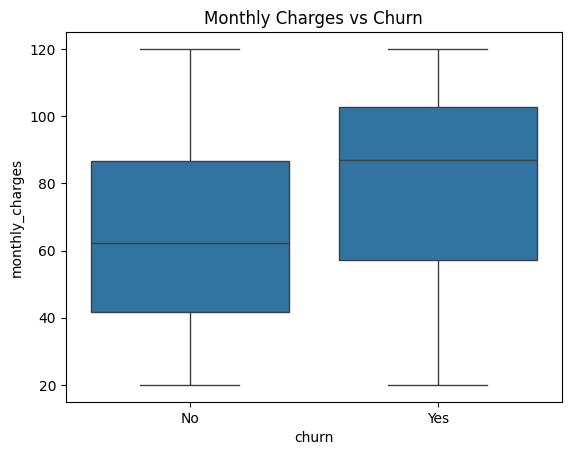

In [18]:
#High monthly charges → higher churn risk
sns.boxplot(x="churn", y="monthly_charges", data=data)
plt.title("Monthly Charges vs Churn")
plt.show()
# Customers with higher monthly charges tend to churn more.

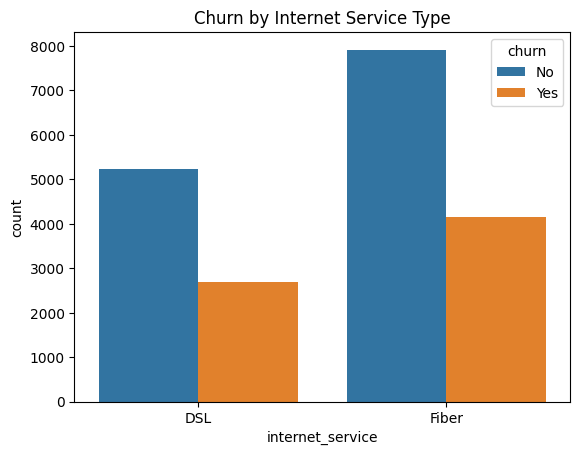

In [19]:
sns.countplot(x="internet_service", hue="churn", data=data)
plt.title("Churn by Internet Service Type")
plt.show()
#Customers with low tenure have a higher probability of churn.


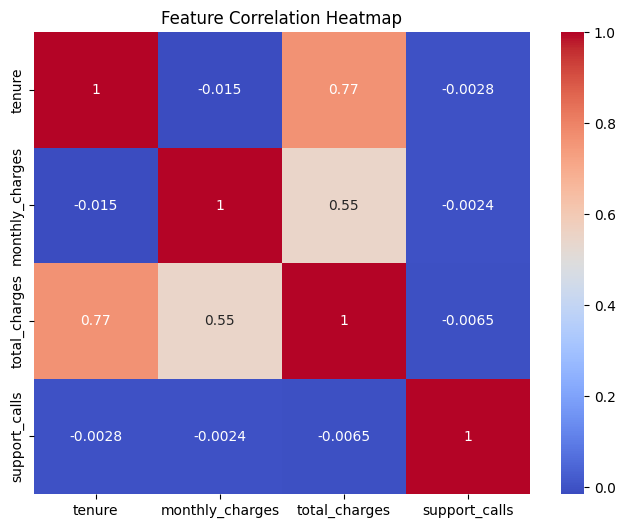

In [20]:

plt.figure(figsize=(8,6))
sns.heatmap(data.select_dtypes(include="number").corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
#This helps identify important numerical features for model training.

In [21]:
### Converting cat data into numerical 


In [22]:
cat_cols=['tenure', 'monthly_charges', 'total_charges', 'contract',
       'payment_method', 'internet_service', 'tech_support', 'online_security',
       'support_calls', 'churn']
for col in cat_cols:
    if data[col].dtype=='object':
        data[col]=LabelEncoder().fit_transform(data[col])
data

,tenure,monthly_charges,total_charges,contract,payment_method,internet_service,tech_support,online_security,support_calls,churn
0,52,54.20,2818.40,0,1,0,0,1,1,0
1,15,35.28,529.20,0,2,0,0,0,2,0
2,72,78.24,5633.28,0,2,0,0,0,0,0
3,61,80.24,4894.64,1,0,1,1,1,0,0
4,21,39.38,826.98,0,3,1,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...
19995,36,69.51,2502.36,2,0,0,0,1,0,1
19996,10,59.88,598.80,0,3,1,1,0,1,0
19997,6,42.96,257.76,0,1,1,0,0,2,0
19998,7,102.85,719.95,0,2,0,1,0,2,0


In [23]:
### Feature Engineering

In [24]:
x=data.drop("churn",axis=1)
y=data["churn"]

In [25]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((16000, 9), (4000, 9), (16000,), (4000,))

In [26]:
## Standard Scaler

In [27]:
scaler = StandardScaler()
X_train_scaled =scaler.fit_transform(x_train)
X_test_scaled =scaler.transform(x_test)


### Linear Model

In [28]:
model=LogisticRegression()
model.fit(X_train_scaled,y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [29]:
yhat_train=model.predict(X_train_scaled)
yhat_test=model.predict(X_test_scaled)

In [30]:
print(confusion_matrix(y_train,yhat_train))
print(classification_report(y_train,yhat_train))

[[9471 1041]
 [2622 2866]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84     10512
           1       0.73      0.52      0.61      5488

    accuracy                           0.77     16000
   macro avg       0.76      0.71      0.72     16000
weighted avg       0.77      0.77      0.76     16000



In [31]:
print(confusion_matrix(y_test,yhat_test))
print(classification_report(y_test,yhat_test))

[[2392  253]
 [ 624  731]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.85      2645
           1       0.74      0.54      0.63      1355

    accuracy                           0.78      4000
   macro avg       0.77      0.72      0.74      4000
weighted avg       0.78      0.78      0.77      4000



### Pipelining

In [32]:
categorical=['contract','payment_method','internet_service','tech_support','online_security']
numeric=['tenure','monthly_charges','total_charges','support_calls']

In [33]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numeric)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression())
])

In [34]:
pipeline.fit(x_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [35]:
pipeline_train=pipeline.predict(x_train)
pipeline_test=pipeline.predict(x_test)

[[9428 1084]
 [2495 2993]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     10512
           1       0.73      0.55      0.63      5488

    accuracy                           0.78     16000
   macro avg       0.76      0.72      0.73     16000
weighted avg       0.77      0.78      0.77     16000



<Axes: >

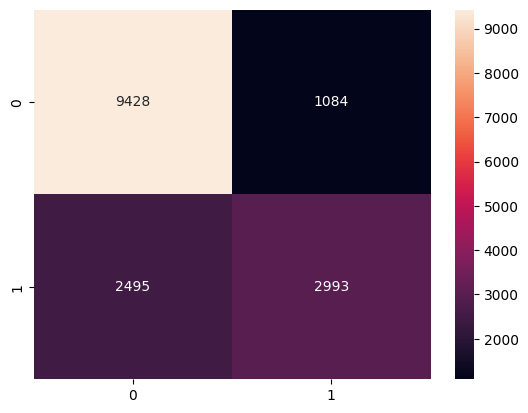

In [36]:
print(confusion_matrix(y_train,pipeline_train))
print(classification_report(y_train,pipeline_train))
sns.heatmap(confusion_matrix(y_train,pipeline_train),annot=True,fmt='d')


[[2392  253]
 [ 592  763]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2645
           1       0.75      0.56      0.64      1355

    accuracy                           0.79      4000
   macro avg       0.78      0.73      0.75      4000
weighted avg       0.78      0.79      0.78      4000



<Axes: >

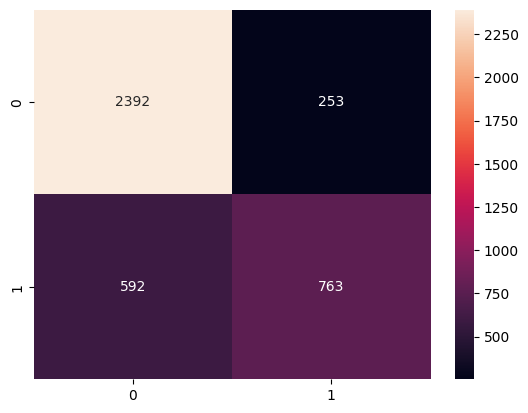

In [37]:
print(confusion_matrix(y_test,pipeline_test))
print(classification_report(y_test,pipeline_test))
sns.heatmap(confusion_matrix(y_test,pipeline_test),annot=True,fmt='d')

In [ ]:
with open("../Model/customer.pkl", "wb") as file:
    pickle.dump(pipeline, file) 